In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [12]:
df = pd.read_csv('./kyber_dilithium_rsa_dataset.csv')

In [13]:
np.random.seed(42)
numeric_noise_level = 0.05
categorical_noise_fraction = 0.05
label_noise_fraction = 0.01

# Numeric noise
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_numeric = ['key_size', 'ct_size']
numeric_cols = [col for col in numeric_cols if col not in exclude_numeric]

for col in numeric_cols:
    col_mean = df[col].mean()
    noise_scale = numeric_noise_level * col_mean
    noise = np.random.normal(0, noise_scale, size=df.shape[0])
    df[col] = df[col] + noise
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype(int)

# Categorical noise (except 'algo')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'algo' in categorical_cols:
    categorical_cols.remove('algo')

for col in categorical_cols:
    n_noisy = int(len(df) * categorical_noise_fraction)
    indices = np.random.choice(df.index, n_noisy, replace=False)
    unique_vals = df[col].unique()
    for i in indices:
        current_val = df.at[i, col]
        other_vals = [val for val in unique_vals if val != current_val]
        df.at[i, col] = np.random.choice(other_vals)

# Label noise
n_label_flip = int(len(df) * label_noise_fraction)
if n_label_flip > 0:
    indices = np.random.choice(df.index, n_label_flip, replace=False)
    unique_labels = df['algo'].unique()
    for i in indices:
        current_label = df.at[i, 'algo']
        other_labels = [label for label in unique_labels if label != current_label]
        df.at[i, 'algo'] = np.random.choice(other_labels)

print("Noise added to dataset.")


Noise added to dataset.


In [14]:
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)',
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)',
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)',
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles',
                       'ct_size', 'key_size']

for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

# Fill missing
df = df.fillna(0)

# Encode categorical
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['algo'])

# Drop target and algo_type if exists
X = df.drop(columns=['algo'])
if 'algo_type' in X.columns:
    X = X.drop(columns=['algo_type'])


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=0.1),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=42)
}

print("\nModel evaluation with noisy dataset:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")



Model evaluation with noisy dataset:


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.842 (+/- 0.034)
Bernoulli Naive Bayes mean CV accuracy: 0.341 (+/- 0.055)
Decision Tree mean CV accuracy: 0.842 (+/- 0.069)


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


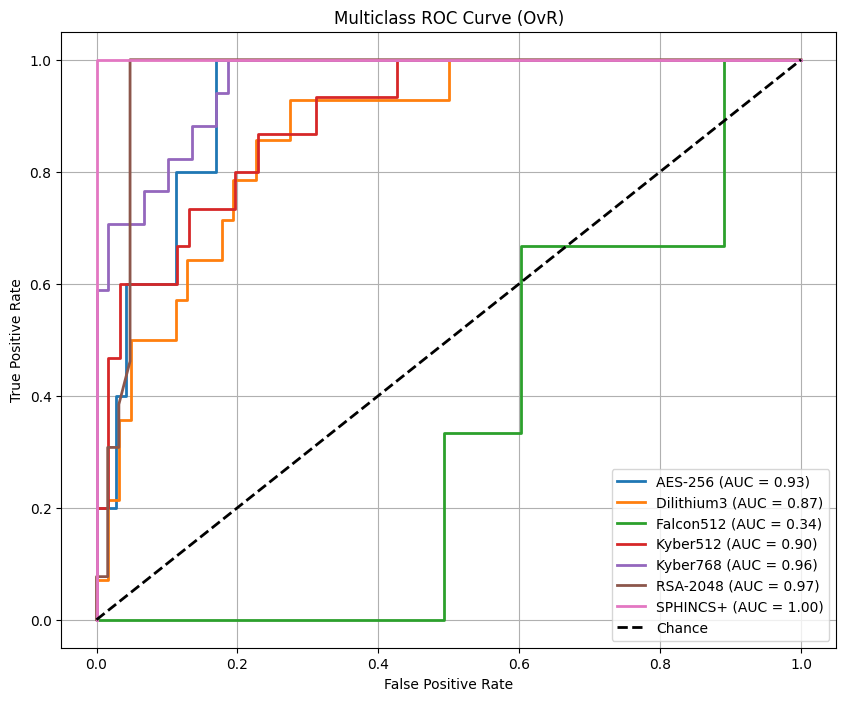

In [16]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Binarize labels
classes = np.unique(y)
y_binarized = label_binarize(y, classes=classes)
n_classes = y_binarized.shape[1]

# ROC Curve (OvR)
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
y_score = cross_val_predict(ovr_model, X_scaled, y, cv=cv, method='predict_proba')

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{target_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


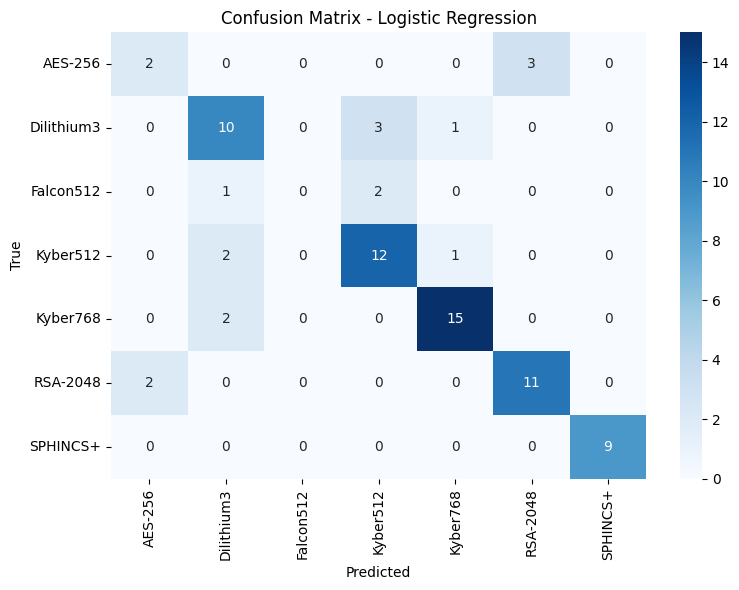

In [17]:
y_pred = cross_val_predict(LogisticRegression(max_iter=1000, random_state=42), X_scaled, y, cv=cv)
conf_mat = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()